### <center> Monte Carlo Simulation for Estimation of Oil Reserves </center>
##### <center> Submitted by Sabyasachi Dash for Class Project PGE 383, Fall 2022 </center>
Monte Carlo simulation is a process of capturing the uncertainty in the estimate of oil reserves using the volumetric method. In this process, we run a model numerous times with a random selection from the input distributions for each  input variable. The results of these numerous scenarios can give us a "most likely" case, along with a statistical distribution to understand the risk or uncertainty involved. It is an alternative to both single-point (deterministic) estimation and the scenario approach that presents worst-case, most-likely, and best-case scenarios.

In this illustration, we demonstrate the estimation of oil in place reserves.
<p>&nbsp;</p>
<center style="font-size:22px;">$N = \frac{7758 \times A \times h \times \phi \times (1-S_w)}{B_o}$</center>

The input parameters are the area ($A$) in acre, thickness of the net reservoir ($h$) in ft, porosity ($\phi$), water saturation ($S_w$), and formation volume factor ($B_o$). The output is the oil in place ($N$) in barrels.

**Definitions:**
* P90: 90% probability of occurence of an event or parameter. This is equivalent to the 10th percentile in statistics.
* P10: 10% probability of occurence of an event or parameter. This is equivalent to the 90th percentile in statistics.
* Pmean: Mean occurence of the event or parameter.
* Pmedian: 50th percentile of occurence of an even or parameter.
* Pmode: The maximum likelihood of occurence of an event or parameter.

The distribution of the input parameters generally take P90 and P10 as input. These P90 and P10 can be the minimum and maximum of the bootstrap average values. Doing this allows for uncertainty in bootstrap to be captured as there might have been cases where we maynot have sampled the absolute minimum or maximum in the spatial context.

In [1]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, lognorm, truncnorm, uniform, triang
import ipywidgets as wid
from ipywidgets import BoundedFloatText, IntSlider
from ipywidgets import Layout
from ipywidgets import Label
from tqdm import tqdm
import random
import geostatspy.GSLIB as GSLIB
import warnings
warnings.filterwarnings("ignore")

#### <center> Bootstrapping </center>
The next section of code is for bootstrapping the porosity, water saturation and thickness of the reservoir from 10 drilled wells. Code from workflow developed by **Dr. Michael Pyrcz, The University of Texas at Austin.**

In [2]:
# function for bootstrapping properties from drilled wells
def bootstrap(df, column, nreal, L):
    if column is None:
        data = []
    else:
        data = df[column]
        
    samples = np.zeros((nreal,len(df))); mean = np.zeros(L); stdev = np.zeros(L)

    for ireal in tqdm(range(0,nreal)):
        samples[ireal] = random.choices(data.values, k=len(df))

    for l in tqdm(range(0,L)):
        samples = random.choices(data.values, k=len(df))
        mean[l] = np.average(samples)
        stdev[l] = np.std(samples)

    mini_mean, maxi_mean = (min(mean))*0.8, (max(mean))*1.2
    mini_std, maxi_std = (min(stdev))*0.8, (max(stdev))*1.2
    plt.subplot(121)
    GSLIB.hist_st(mean,(mini_mean),(maxi_mean),False,False,50,None,'Average {fname}'.format(fname=column),'Bootstrap Uncertainty in {fname} Average'.format(fname=column))

    plt.subplot(122)
    GSLIB.hist_st(stdev,(mini_std),(maxi_std),False,False,50,None,'Standard Deviation {fname}'.format(fname=column),'Bootstrap Uncertainty in {fname} Standard Deviation'.format(fname=column))
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
    plt.show()   

    print('Summary Statistics for Bootstrap {fname} Average:'.format(fname=column))
    print(stats.describe(mean))
    print('\nUncertainty in {fname} Average: P10 '.format(fname=column) + str(round(np.percentile(mean,10),1)) + '%, P50 ' + str(round(np.percentile(mean,50)*100,1)) + '%, P90 ' + str(round(np.percentile(mean,90),1)) +"%") 

    print('\nSummary Statistics for Bootstrap {fname} Standard Deviation:'.format(fname=column))
    print(stats.describe(stdev)); 
    print('\nUncertainty in {fname} Standard Deviation: P10 '.format(fname=column) + str(round(np.percentile(stdev,10),3)) + '%, P50 ' + str(round(np.percentile(stdev,50),3)*100) + '%, P90 ' + str(round(np.percentile(stdev,90),1)) + "%")

#### <center> Sampling Realizations for Monte Carlo simulation </center>
This section defines functions for the no. of sampling and the bins for producing the histograms as global parameters

In [3]:
# Global slider function for defining the no. of samples to be drawn from each parameter and the binning for histogram plot
def on_change_nsample(v):
    nsample.clear()
    nsample.append(v)
    return v
def on_change_bins(k):
    bins.clear()
    bins.append(k)
    return k

#### <center> Truncated Normal Distribution </center>
This section defines the truncated normal distribution to be used for sampling input parameters.
<p>&nbsp;</p>
Let $-\infty$ $\le$ $a$ $<$ $b$ $\le$ $\infty$. Let the pdf of the truncated normal distribution be bounded by $a$ $\le$ $x$ $\le$ $b$. The pdf of the truncated normal distribution is defined as follows:
$$ f(x) = \frac{\phi(x,\mu,\sigma)}{\psi(b,\mu,\sigma) - \psi(a,\mu,\sigma)}$$
where $\phi$ is the pdf and $\psi$ is the cdf of untruncated normal distribution with mean $\mu$ and variance $\sigma^2$.

$$ \phi(x,\mu,\sigma) = \left\{
\begin{array}{\\}
    0 & x<a \\
    0 & x>b \\
    \phi(x,\mu,\sigma) & otherwise \\
\end{array}
\right. $$

$$ \psi(x,\mu,\sigma) = \left\{
\begin{array}{\\}
    0 & x<a \\
    1 & x>b \\
    \psi(x,\mu,\sigma) & otherwise \\
\end{array}
\right. $$

The cdf of the truncated normal distribution is defined as follows:
$$ F(x) = \frac{\psi(x,\mu,\sigma) - \psi(a,\mu,\sigma)}{\psi(b,\mu,\sigma) - \psi(a,\mu,\sigma)}$$

The mean, median, and mode of the truncated normal distribution may change depending on the effect of the upper and lower limit on the original mean. The code recalculates the mean, median, and mode as well as P90 and P10 values.

In [4]:
# Defining all the functions for distributions and callbacks for interactivity

# normal distribution
def normal_dist(P90, P10, lower_limit, upper_limit):
    mu = (P10 + P90) / 2
    sigma = (P10 - P90) / (2*1.28)
    a, b = (lower_limit - mu) / sigma, (upper_limit - mu) / sigma
    if not nsample:
        nsample_ = 100
    else:
        nsample_ = nsample[0]['new']
    if not bins:
        binsw = 100
    else:
        binsw = bins[0]['new']
    sample = truncnorm.rvs(a=a, b=b, loc=mu, scale=sigma, size=nsample_)
    hist, bins_ = np.histogram(sample, binsw, density=True)
    x = np.linspace(min(bins_), max(bins_), 10000)
    pdf = truncnorm.pdf(x, a=a, b=b, loc=mu, scale=sigma)
    cdf = truncnorm.cdf(x, a=a, b=b, loc=mu, scale=sigma)
    
    # calculating statistics of normal distribution
    trunc_mu = (np.sum(x*pdf)) * (max(x) - min(x)) / (len(x))
    k90 = np.argmin(np.absolute(cdf - 0.1))
    k10 = np.argmin(np.absolute(cdf - 0.9))
    kmu = np.argmin(np.absolute(x - trunc_mu))
    kmed = np.argmin(np.absolute(cdf - 0.5))
    kmod = np.argmax(pdf)
    trunc_med, trunc_mod = x[kmed], x[kmod]
    pdf90, pdf10, pdf_mu, pdf_med, pdf_mod = pdf[k90], pdf[k10], pdf[kmu], pdf[kmed], pdf[kmod]
    cdf_mu, cdf_mod = cdf[kmu], cdf[kmod]
    x_90, x_10 = x[k90], x[k10]
    return sample, x, pdf, cdf, x_90, x_10, trunc_mu, trunc_med, trunc_mod, pdf90, pdf10, pdf_mu, pdf_med, pdf_mod, cdf_mu, cdf_mod

# callback for normal distribution
def create_plot_normal(Name):
    
    names = ['P90', 'P10', 'lower_limit', 'upper_limit']
    objects = []
    objects.append(BoundedFloatText(value=25.0, min=0, max=1e10, step=0.1, description='P90'))
    objects.append(BoundedFloatText(value=55.0, min=0, max=1e10, step=0.1, description='P10'))
    objects.append(BoundedFloatText(value=0, min=0, max=1e10, step=0.1, description='lower_limit'))
    objects.append(BoundedFloatText(value=100, min=0, max=1e10, step=0.1, description='upper_limit'))
    
    arg_dict = {names[i]: BoundedFloatText for i, BoundedFloatText in enumerate(objects)}
    
    k = 'Sampling for '+ Name + ' Using Normal Distribution'
    l = Label(k, layout=Layout(display="flex", justify_content="center"), style={'font_weight': 'bold', 'font_size':'20px'})
    uh = wid.HBox(children=objects)
    u = wid.VBox([l, uh],)
    
    mysample  = []
    def create_graph(**kwargs):
        mysample.clear()
        sample_, x, pdf, cdf, x_90, x_10, trunc_mu, trunc_med, trunc_mod, pdf90, pdf10, pdf_mu, pdf_med, pdf_mod, cdf_mu, cdf_mod = normal_dist(**kwargs)
        mysample.append(sample_)
        if not bins:
            binsw = 100
        else:
            binsw = bins[0]['new']
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))
        ax1.hist(sample_, binsw, density=True, align='mid')                                           # plot samples drawn
        ax1.plot(x, pdf, linewidth=2, color='r')                                                      # plot pdf
        y1min = ax1.axes.get_ylim()[0]
        y1max = ax1.axes.get_ylim()[1]
        y1_90 = (pdf90 - y1min) / (y1max-y1min)
        y1_10 = (pdf10 - y1min) / (y1max-y1min)
        y1_mu = (pdf_mu - y1min) / (y1max-y1min)
        y1_med = (pdf_med - y1min) / (y1max-y1min)
        y1_mod = (pdf_mod - y1min) / (y1max-y1min)
        ax1.axvline(x=x_90, ymin=0, ymax=y1_90, color='orange', linestyle='--', linewidth = 2, label=('P90: {:,.1f}'.format(x_90)))      # plot P90 and P10 on pdf
        ax1.axvline(x=x_10, ymin=0, ymax=y1_10, color='lime', linestyle='--', linewidth = 2, label=('P10: {:,.1f}'.format(x_10)))
        ax1.axvline(x=trunc_mu, ymin=0, ymax=y1_mu, color='fuchsia', linestyle='--', linewidth = 2, label=('Pmean: {:,.1f}'.format(trunc_mu)))
        ax1.axvline(x=trunc_med, ymin=0, ymax=y1_med, color='navy', linestyle='--', linewidth = 2, label=('Pmedian: {:,.1f}'.format(trunc_med)))
        ax1.axvline(x=trunc_mod, ymin=0, ymax=y1_mod, color='aqua', linestyle='--', linewidth = 2, label=('Pmode: {:,.1f}'.format(trunc_mod)))
        ax2.plot(x, cdf, linewidth=2, color='r')                                                      # plot cdf
        y2min = ax2.axes.get_ylim()[0]
        y2max = ax2.axes.get_ylim()[1]
        y2_90 = (0.1 - y2min) / (y2max-y2min)
        y2_10 = (0.9 - y2min) / (y2max-y2min)
        y2_mu = (cdf_mu - y2min) / (y2max-y2min)
        y2_med = (0.5 - y2min) / (y2max-y2min)
        y2_mod = (cdf_mod - y2min) / (y2max-y2min)
        ax2.axvline(x=x_90, ymin=0, ymax=y2_90, color='orange', linestyle='--', linewidth = 2, label=('P90: {:,.1f}'.format(x_90)))      # plot P90 and P10 on cdf
        ax2.axvline(x=x_10, ymin=0, ymax=y2_10, color='lime', linestyle='--', label=('P10: {:,.1f}'.format(x_10)))
        ax2.axvline(x=trunc_mu, ymin=0, ymax=y2_mu, color='fuchsia', linestyle='--', linewidth = 2, label=('Pmean: {:,.1f}'.format(trunc_mu)))
        ax2.axvline(x=trunc_med, ymin=0, ymax=y2_med, color='navy', linestyle='--', linewidth = 2, label=('Pmedian: {:,.1f}'.format(trunc_med)))
        ax2.axvline(x=trunc_mod, ymin=0, ymax=y2_mod, color='aqua', linestyle='--', linewidth = 2, label=('Pmode: {:,.1f}'.format(trunc_mod)))
        x2min = ax2.axes.get_xlim()[0]
        x2max = ax2.axes.get_xlim()[1]
        x2_90 = (x_90 - x2min) / (x2max-x2min)
        x2_10 = (x_10 - x2min) / (x2max-x2min)
        x2_mu = (trunc_mu - x2min) / (x2max-x2min)
        x2_med = (trunc_med - x2min) / (x2max-x2min)
        x2_mod = (trunc_mod - x2min) / (x2max-x2min)
        ax2.axhline(y=0.1, xmin=0, xmax=x2_90, color='orange', linestyle='-', linewidth = 2)                   # plot P90 and P10 on cdf
        ax2.axhline(y=0.9, xmin=0, xmax=x2_10, color='lime', linestyle='-', linewidth = 2)
        ax2.axhline(y=cdf_mu, xmin=0, xmax=x2_mu, color='fuchsia', linestyle='-', linewidth = 2)
        ax2.axhline(y=0.5, xmin=0, xmax=x2_med, color='navy', linestyle='-', linewidth = 2)
        ax2.axhline(y=cdf_mod, xmin=0, xmax=x2_mod, color='aqua', linestyle='-', linewidth = 2)
        ax1.legend()
        ax2.legend()
#         plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
        plt.show()
    
    interactive_plot = wid.interactive_output(create_graph, arg_dict)
    interactive_plot.clear_output(wait = True)
    display(u, interactive_plot)
    return mysample

#### <center> Truncated LogNormal Distribution </center>
This section defines the truncated lognormal distribution to be used for sampling input parameters.
<p>&nbsp;</p>
Let $-\infty$ $\le$ $a$ $<$ $b$ $\le$ $\infty$. Rest follows similarly from the truncated normal sections for defining the pdf and the cdf of the truncated lognormal distribution.

The lognormal distribution defined in scipy takes $\mu$ and $\sigma$, which are standard equivalent of the lognormal distribution as input.

Let $Z$ be a standard normal variable, then the distribution of the random variable $X = e^{\mu+Z\sigma}$ is lognormal.

P90 is the 10th percentile $e^{\mu+\sigma.Z_{0.10}} = P90\ value$\
P10 is the 90th percentile $e^{\mu+\sigma.Z_{0.90}} = P10\ value$

<p style="font-size:18px;">$\sigma = \frac{(Ln(\frac{P10\ value}{P90\ value}))}{Z_{0.90} - Z_{0.10}}$<p>
The calculation of $\mu$ follows from there on.

In [5]:
# truncated lognormal distribution
def lognormal_dist(P90, P10, lower_limit, upper_limit):
    sig = np.log(P10/P90) / (2*1.282)
    mu = np.log(P10) - (1.282*sig)
    log_mu = np.exp(mu + (sig**2 / 2))
    
    if not nsample:
        nsample_ = 100
    else:
        nsample_ = nsample[0]['new']
    if not bins:
        binsw = 100
    else:
        binsw = bins[0]['new']
    sample = lognorm.rvs(s=sig, loc=mu, scale=np.exp(mu), size=nsample_)
    
    for j in range(len(sample)):
        while (sample[j] < lower_limit) or (sample[j] > upper_limit):
            sample[j] = lognorm.rvs(s=sig, loc=mu, scale=np.exp(mu), size=1)
    hist, bins_ = np.histogram(sample, binsw, density=True)
    x = np.linspace(min(bins_), max(bins_), 10000)
    untruc_pdf = lognorm.pdf(x, s=sig, loc=mu, scale=np.exp(mu))
    untrunc_cdf = lognorm.cdf(x, s=sig, loc=mu, scale=np.exp(mu))
    cdf_b = lognorm.cdf(upper_limit, s=sig, loc=mu, scale=np.exp(mu))
    cdf_a = lognorm.cdf(lower_limit, s=sig, loc=mu, scale=np.exp(mu))
    trun_pdf = untruc_pdf/(cdf_b-cdf_a)
    trun_cdf = (untrunc_cdf - cdf_a) / (cdf_b - cdf_a)
    trunc_pdf = np.empty(len(x))
    trunc_cdf = np.empty(len(x))
    for i in range(len(x)):
        if x[i] <= lower_limit:
            trunc_pdf[i] = 0
            trunc_cdf[i] = 0
        elif x[i] >= upper_limit:
            trunc_pdf[i] = 0
            trunc_cdf[i] = 1
        else:
            trunc_pdf[i] = trun_pdf[i]
            trunc_cdf[i] = trun_cdf[i]
    
    # calculating statistics of lognormal distribution
    trunc_mu = (np.sum(x*trunc_pdf)) * (max(x) - min(x)) / (len(x))
    k90 = np.argmin(np.absolute(trunc_cdf - 0.1))
    k10 = np.argmin(np.absolute(trunc_cdf - 0.9))
    kmu = np.argmin(np.absolute(x - trunc_mu))
    kmed = np.argmin(np.absolute(trunc_cdf - 0.5))
    kmod = np.argmax(trunc_pdf)
    log_mod, log_med = x[kmod], x[kmed]
    pdf90, pdf10, pdf_mu, pdf_med, pdf_mod = trunc_pdf[k90], trunc_pdf[k10], trunc_pdf[kmu], trunc_pdf[kmed], trunc_pdf[kmod]
    cdf_mu, cdf_mod = trunc_cdf[kmu], trunc_cdf[kmod]
    x_90, x_10 = x[k90], x[k10]
    
    return sample, x, trunc_pdf, trunc_cdf, x_90, x_10, trunc_mu, log_med, log_mod, pdf90, pdf10, pdf_mu, pdf_med, pdf_mod, cdf_mu, cdf_mod

# callback for lognormal distribution
def create_plot_lognormal(Name):
    names = ['P90', 'P10', 'lower_limit', 'upper_limit']
    objects = []
    objects.append(BoundedFloatText(value=1000, min=0, max=1e10, step=0.1, description='P90'))
    objects.append(BoundedFloatText(value=3000, min=0, max=1e10, step=0.1, description='P10'))
    objects.append(BoundedFloatText(value=0, min=0, max=1e10, step=0.1, description='lower_limit'))
    objects.append(BoundedFloatText(value=200000, min=0, max=1e10, step=0.1, description='upper_limit'))
    
    arg_dict = {names[i]: BoundedFloatText for i, BoundedFloatText in enumerate(objects)}
    
    k = 'Sampling for '+ Name + ' Using Log-Normal Distribution'
    l = Label(k, layout=Layout(display="flex", justify_content="center"), style={'font_weight': 'bold', 'font_size':'20px'})
    uh = wid.HBox(children=objects)
    u = wid.VBox([l, uh],)
    
    mysample  = []
    def create_graph(**kwargs):
        mysample.clear()
        sample_, x, pdf, cdf, x_90, x_10, trunc_mu, log_med, log_mod, pdf90, pdf10, pdf_mu, pdf_med, pdf_mod, cdf_mu, cdf_mod = lognormal_dist(**kwargs)
        mysample.append(sample_)
        if not bins:
            binsw = 100
        else:
            binsw = bins[0]['new']
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))
        ax1.hist(sample_, binsw, density=True, align='mid')                                           # plot samples drawn
        ax1.plot(x, pdf, linewidth=2, color='r')
        y1min = ax1.axes.get_ylim()[0]
        y1max = ax1.axes.get_ylim()[1]
        y1_90 = (pdf90 - y1min) / (y1max-y1min)
        y1_10 = (pdf10 - y1min) / (y1max-y1min)
        y1_mu = (pdf_mu - y1min) / (y1max-y1min)
        y1_med = (pdf_med - y1min) / (y1max-y1min)
        y1_mod = (pdf_mod - y1min) / (y1max-y1min)
        ax1.axvline(x=x_90, ymin=0, ymax=y1_90, color='orange', linestyle='--', linewidth = 2, label=('P90: {:,.1f}'.format(x_90)))      # plot P90 and P10 on pdf
        ax1.axvline(x=x_10, ymin=0, ymax=y1_10, color='lime', linestyle='--', linewidth = 2, label=('P10: {:,.1f}'.format(x_10)))
        ax1.axvline(x=trunc_mu, ymin=0, ymax=y1_mu, color='fuchsia', linestyle='--', linewidth = 2, label=('Pmean: {:,.1f}'.format(trunc_mu)))
        ax1.axvline(x=log_med, ymin=0, ymax=y1_med, color='navy', linestyle='--', linewidth = 2, label=('Pmedian: {:,.1f}'.format(log_med)))
        ax1.axvline(x=log_mod, ymin=0, ymax=y1_mod, color='aqua', linestyle='--', linewidth = 2, label=('Pmode: {:,.1f}'.format(log_mod)))
        ax2.plot(x, cdf, linewidth=2, color='r')
        y2min = ax2.axes.get_ylim()[0]
        y2max = ax2.axes.get_ylim()[1]
        y2_90 = (0.1 - y2min) / (y2max-y2min)
        y2_10 = (0.9 - y2min) / (y2max-y2min)
        y2_mu = (cdf_mu - y2min) / (y2max-y2min)
        y2_med = (0.5 - y2min) / (y2max-y2min)
        y2_mod = (cdf_mod - y2min) / (y2max-y2min)
        ax2.axvline(x=x_90, ymin=0, ymax=y2_90, color='orange', linestyle='--', linewidth = 2, label=('P90: {:,.1f}'.format(x_90)))      # plot P90 and P10 on cdf
        ax2.axvline(x=x_10, ymin=0, ymax=y2_10, color='lime', linestyle='--', label=('P10: {:,.1f}'.format(x_10)))
        ax2.axvline(x=trunc_mu, ymin=0, ymax=y2_mu, color='fuchsia', linestyle='--', linewidth = 2, label=('Pmean: {:,.1f}'.format(trunc_mu)))
        ax2.axvline(x=log_med, ymin=0, ymax=y2_med, color='navy', linestyle='--', linewidth = 2, label=('Pmedian: {:,.1f}'.format(log_med)))
        ax2.axvline(x=log_mod, ymin=0, ymax=y2_mod, color='aqua', linestyle='--', linewidth = 2, label=('Pmode: {:,.1f}'.format(log_mod)))
        x2min = ax2.axes.get_xlim()[0]
        x2max = ax2.axes.get_xlim()[1]
        x2_90 = (x_90 - x2min) / (x2max-x2min)
        x2_10 = (x_10 - x2min) / (x2max-x2min)
        x2_mu = (trunc_mu - x2min) / (x2max-x2min)
        x2_med = (log_med - x2min) / (x2max-x2min)
        x2_mod = (log_mod - x2min) / (x2max-x2min)
        ax2.axhline(y=0.1, xmin=0, xmax=x2_90, color='orange', linestyle='-', linewidth = 2)                   # plot P90 and P10 on cdf
        ax2.axhline(y=0.9, xmin=0, xmax=x2_10, color='lime', linestyle='-', linewidth = 2)
        ax2.axhline(y=cdf_mu, xmin=0, xmax=x2_mu, color='fuchsia', linestyle='-', linewidth = 2)
        ax2.axhline(y=0.5, xmin=0, xmax=x2_med, color='navy', linestyle='-', linewidth = 2)
        ax2.axhline(y=cdf_mod, xmin=0, xmax=x2_mod, color='aqua', linestyle='-', linewidth = 2)
        ax1.legend()
        ax2.legend()
        plt.show()

    interactive_plot = wid.interactive_output(create_graph, arg_dict)
    interactive_plot.clear_output(wait = True)
    display(u, interactive_plot)
    return mysample

#### <center> Uniform Distribution </center>
This section defines the uniform distribution to be used for sampling input parameters.
<p>&nbsp;</p>
The pdf $f(x)$ and the cdf $F(x)$ for a continuous distribution in the interval $[a, b]$ are

<p style="font-size:14px;">$$ f(x) = \left\{
\begin{array}{\\}
    0 & x<a \\
    \frac{1}{b-a} & a\le x \le b \\
    0 & x>b \\
\end{array}
\right. $$<p>

<p style="font-size:14px;">$$ F(x) = \left\{
\begin{array}{\\}
    0 & x<a \\
    \frac{x-a}{b-a} & a\le x \le b \\
    1 & x>b \\
\end{array}
\right. $$<p>

In [6]:
# uniform distribution

def uniform_dist(minima, maxima):
    a, b = minima, (maxima - minima)
    if not nsample:
        nsample_ = 100
    else:
        nsample_ = nsample[0]['new']
    if not bins:
        binsw = 100
    else:
        binsw = bins[0]['new']
        
    sample = uniform.rvs(loc=a, scale=b, size=nsample_)
    hist, bins_ = np.histogram(sample, binsw, density=True)
    x = np.linspace(min(bins_), max(bins_), 10000)
    pdf = uniform.pdf(x, loc=a, scale=b)
    cdf = uniform.cdf(x, loc=a, scale=b)
    
    # calculating statistics of uniform distribution
    mu = (maxima + minima)/2
    kmu = np.argmin(np.absolute(x - mu))
    pdf_mu, cdf_mu =  pdf[kmu], cdf[kmu]
    
    return sample, x, pdf, cdf, kmu, pdf_mu, cdf_mu, mu

# callback for uniform distribution
def create_plot_uniform(Name):
    names = ['minima', 'maxima']
    objects = []
    objects.append(BoundedFloatText(value=1.1, min=0, max=1e10, step=0.01, description='Minimum'))
    objects.append(BoundedFloatText(value=1.25, min=0, max=1e10, step=0.01, description='Maximum'))
    
    arg_dict = {names[i]: BoundedFloatText for i, BoundedFloatText in enumerate(objects)}
    
    k = 'Sampling for '+ Name + ' Using Uniform Distribution'
    l = Label(k, layout=Layout(display="flex", justify_content="center"), style={'font_weight': 'bold', 'font_size':'20px'})
    uh = wid.HBox(children=objects)
    u = wid.VBox([l, uh],)
    
    mysample  = []
    def create_graph(**kwargs):
        mysample.clear()
        sample_, x, pdf, cdf, kmu, pdf_mu, cdf_mu, mu = uniform_dist(**kwargs)
        mysample.append(sample_)
        if not bins:
            binsw = 100
        else:
            binsw = bins[0]['new']
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))
        ax1.hist(sample_, binsw, density=True, align='mid')                                           # plot samples drawn
        ax1.plot(x, pdf, linewidth=2, color='r')
        y1min = ax1.axes.get_ylim()[0]
        y1max = ax1.axes.get_ylim()[1]
        y1_mu = (pdf_mu - y1min) / (y1max-y1min)
        ax1.axvline(x=mu, ymin=0, ymax=y1_mu, color='fuchsia', linestyle='--', linewidth = 2, label=('Pmean: {:,.2f}'.format(mu)))
        ax2.plot(x, cdf, linewidth=2, color='r')
        y2min = ax2.axes.get_ylim()[0]
        y2max = ax2.axes.get_ylim()[1]
        y2_mu = (cdf_mu - y2min) / (y2max-y2min)
        ax2.axvline(x=mu, ymin=0, ymax=y2_mu, color='fuchsia', linestyle='--', linewidth = 2, label=('Pmean: {:,.2f}'.format(mu)))
        x2min = ax2.axes.get_xlim()[0]
        x2max = ax2.axes.get_xlim()[1]
        x2_mu = (mu - x2min) / (x2max-x2min)
        ax2.axhline(y=cdf_mu, xmin=0, xmax=x2_mu, color='fuchsia', linestyle='-', linewidth = 2)
        ax1.legend()
        ax2.legend()
        plt.show()
        
    interactive_plot = wid.interactive_output(create_graph, arg_dict)
    interactive_plot.clear_output(wait = True)
    display(u, interactive_plot)
    return mysample

#### <center> Triangular Distribution </center>
This section defines the uniform distribution to be used for sampling input parameters.
<p>&nbsp;</p>
The pdf $f(x)$ and the cdf $F(x)$ for a continuous distribution in the interval $[a, b]$ with peak at $c$ are

<p style="font-size:14px;">$$ f(x) = \left\{
\begin{array}{\\}
    0 & x<a \\
    \frac{2(x-a)}{(b-a)(c-a)} & a \le x \le c \\
    \frac{2(b-x)}{(b-a)(b-c)} & c \le x \le b \\
    0 & x>b \\
\end{array}
\right. $$<p>

<p style="font-size:14px;">$$ F(x) = \left\{
\begin{array}{\\}
    0 & x \le a \\
    \frac{(x-a)^2}{(b-a)(c-a)} & a< x \le c \\
    1 - \frac{(b-x)^2}{(b-a)(b-c)} & c < x < b \\
    1 & x \ge b \\
\end{array}
\right. $$<p>

In [7]:
# triangular distribution
def triang_dist(minima, maxima, most_likely):
    loc, scale, c = minima, (maxima-minima), ((most_likely-minima)/(maxima-minima))
    if not nsample:
        nsample_ = 100
    else:
        nsample_ = nsample[0]['new']
    if not bins:
        binsw = 100
    else:
        binsw = bins[0]['new']
    sample = triang.rvs(c, loc=loc, scale=scale, size=nsample_)
    hist, bins_ = np.histogram(sample, binsw, density=True)
    x = np.linspace(min(bins_), max(bins_), 10000)
    pdf = triang.pdf(x, c, loc=loc, scale=scale)
    cdf = triang.cdf(x, c, loc=loc, scale=scale)
    
    # calculating statistics of normal distribution
    mean = (np.sum(x*pdf)) * (max(x) - min(x)) / (len(x))
    k90 = np.argmin(np.absolute(cdf - 0.1))
    k10 = np.argmin(np.absolute(cdf - 0.9))
    kmean = np.argmin(np.absolute(x - mean))
    kmed = np.argmin(np.absolute(cdf - 0.5))
    kmod = np.argmax(pdf)
    median, mode = x[kmed], x[kmod]
    pdf90, pdf10, pdf_mean, pdf_med, pdf_mod = pdf[k90], pdf[k10], pdf[kmean], pdf[kmed], pdf[kmod]
    cdf_mean, cdf_mod = cdf[kmean], cdf[kmod]
    x_90, x_10 = x[k90], x[k10]
    return sample, x, pdf, cdf, x_90, x_10, mean, median, mode, pdf90, pdf10, pdf_mean, pdf_med, pdf_mod, cdf_mean, cdf_mod

# callback for normal distribution
def create_plot_triang(Name):
    
    names = ['minima', 'maxima', 'most_likely']
    objects = []
    objects.append(BoundedFloatText(value=20.0, min=0, max=1e10, step=0.1, description='Minimum'))
    objects.append(BoundedFloatText(value=45.0, min=0, max=1e10, step=0.1, description='Maximum'))
    objects.append(BoundedFloatText(value=30.0, min=0, max=1e10, step=0.1, description='Peak Value'))
    
    arg_dict = {names[i]: BoundedFloatText for i, BoundedFloatText in enumerate(objects)}
    
    k = 'Sampling for '+ Name + ' Using Triangular Distribution'
    l = Label(k, layout=Layout(display="flex", justify_content="center"), style={'font_weight': 'bold', 'font_size':'20px'})
    uh = wid.HBox(children=objects)
    u = wid.VBox([l, uh],)
    
    mysample  = []
    def create_graph(**kwargs):
        mysample.clear()
        sample_, x, pdf, cdf, x_90, x_10, mean, median, mode, pdf90, pdf10, pdf_mean, pdf_med, pdf_mod, cdf_mean, cdf_mod = triang_dist(**kwargs)
        mysample.append(sample_)
        if not bins:
            binsw = 100
        else:
            binsw = bins[0]['new']
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))
        ax1.hist(sample_, binsw, density=True, align='mid')                                           # plot samples drawn
        ax1.plot(x, pdf, linewidth=2, color='r')                                                      # plot pdf
        y1min = ax1.axes.get_ylim()[0]
        y1max = ax1.axes.get_ylim()[1]
        y1_90 = (pdf90 - y1min) / (y1max-y1min)
        y1_10 = (pdf10 - y1min) / (y1max-y1min)
        y1_mean = (pdf_mean - y1min) / (y1max-y1min)
        y1_med = (pdf_med - y1min) / (y1max-y1min)
        y1_mod = (pdf_mod - y1min) / (y1max-y1min)
        ax1.axvline(x=x_90, ymin=0, ymax=y1_90, color='orange', linestyle='--', linewidth = 2, label=('P90: {:,.1f}'.format(x_90)))      # plot P90 and P10 on pdf
        ax1.axvline(x=x_10, ymin=0, ymax=y1_10, color='lime', linestyle='--', linewidth = 2, label=('P10: {:,.1f}'.format(x_10)))
        ax1.axvline(x=mean, ymin=0, ymax=y1_mean, color='fuchsia', linestyle='--', linewidth = 2, label=('Pmean: {:,.1f}'.format(mean)))
        ax1.axvline(x=median, ymin=0, ymax=y1_med, color='navy', linestyle='--', linewidth = 2, label=('Pmedian: {:,.1f}'.format(median)))
        ax1.axvline(x=mode, ymin=0, ymax=y1_mod, color='aqua', linestyle='--', linewidth = 2, label=('Pmode: {:,.1f}'.format(mode)))
        ax2.plot(x, cdf, linewidth=2, color='r')
        y2min = ax2.axes.get_ylim()[0]
        y2max = ax2.axes.get_ylim()[1]
        y2_90 = (0.1 - y2min) / (y2max-y2min)
        y2_10 = (0.9 - y2min) / (y2max-y2min)
        y2_mean = (cdf_mean - y2min) / (y2max-y2min)
        y2_med = (0.5 - y2min) / (y2max-y2min)
        y2_mod = (cdf_mod - y2min) / (y2max-y2min)
        ax2.axvline(x=x_90, ymin=0, ymax=y2_90, color='orange', linestyle='--', linewidth = 2, label=('P90: {:,.1f}'.format(x_90)))      # plot P90 and P10 on cdf
        ax2.axvline(x=x_10, ymin=0, ymax=y2_10, color='lime', linestyle='--', label=('P10: {:,.1f}'.format(x_10)))
        ax2.axvline(x=mean, ymin=0, ymax=y2_mean, color='fuchsia', linestyle='--', linewidth = 2, label=('Pmean: {:,.1f}'.format(mean)))
        ax2.axvline(x=median, ymin=0, ymax=y2_med, color='navy', linestyle='--', linewidth = 2, label=('Pmedian: {:,.1f}'.format(median)))
        ax2.axvline(x=mode, ymin=0, ymax=y2_mod, color='aqua', linestyle='--', linewidth = 2, label=('Pmode: {:,.1f}'.format(mode)))
        x2min = ax2.axes.get_xlim()[0]
        x2max = ax2.axes.get_xlim()[1]
        x2_90 = (x_90 - x2min) / (x2max-x2min)
        x2_10 = (x_10 - x2min) / (x2max-x2min)
        x2_mean = (mean - x2min) / (x2max-x2min)
        x2_med = (median - x2min) / (x2max-x2min)
        x2_mod = (mode - x2min) / (x2max-x2min)
        ax2.axhline(y=0.1, xmin=0, xmax=x2_90, color='orange', linestyle='-', linewidth = 2)                   # plot P90 and P10 on cdf
        ax2.axhline(y=0.9, xmin=0, xmax=x2_10, color='lime', linestyle='-', linewidth = 2)
        ax2.axhline(y=cdf_mean, xmin=0, xmax=x2_mean, color='fuchsia', linestyle='-', linewidth = 2)
        ax2.axhline(y=0.5, xmin=0, xmax=x2_med, color='navy', linestyle='-', linewidth = 2)
        ax2.axhline(y=cdf_mod, xmin=0, xmax=x2_mod, color='aqua', linestyle='-', linewidth = 2)
        ax1.legend()
        ax2.legend()
        plt.show()
        
    interactive_plot = wid.interactive_output(create_graph, arg_dict)
    interactive_plot.clear_output(wait = True)
    display(u, interactive_plot)
    return mysample

In [8]:
well = pd.read_csv('https://raw.githubusercontent.com/Sabya0711/MonteCarlo/main/well_data.csv')
well.head(n=10)

,Well,Porosity,Water Saturation,Thickness
0,Well1,21.8,40.5,31.9
1,Well2,19.9,36.7,27.9
2,Well3,23.5,37.9,31.6
3,Well4,18.1,35.1,49.1
4,Well5,18.9,40.7,45.9
5,Well6,23.4,36.7,53.1
6,Well7,11.4,34.3,34.9
7,Well8,12.4,21.1,40.7
8,Well9,15.5,33.2,42.8
9,Well10,19.3,31.1,48.9


100%|█████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 22330.18it/s]


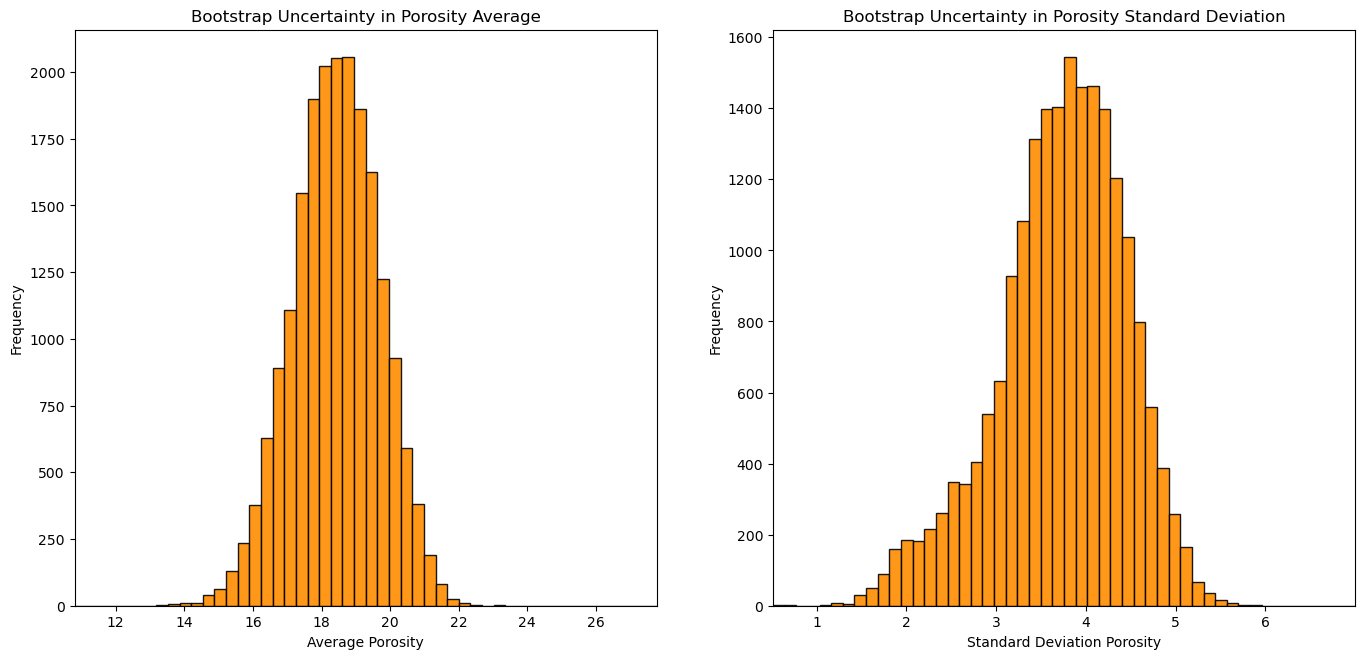

Summary Statistics for Bootstrap Porosity Average:
DescribeResult(nobs=20000, minmax=(13.510000000000002, 23.14), mean=18.42078, variance=1.575099176558828, skewness=-0.1254370693955799, kurtosis=-0.08269689310073502)

Uncertainty in Porosity Average: P10 16.8%, P50 1844.0%, P90 20.0%

Summary Statistics for Bootstrap Porosity Standard Deviation:
DescribeResult(nobs=20000, minmax=(0.6415605972938168, 5.830403073544744), mean=3.72508786275323, variance=0.5106966195995514, skewness=-0.5272540998844489, kurtosis=0.23620160940626178)

Uncertainty in Porosity Standard Deviation: P10 2.754%, P50 379.2%, P90 4.6%


In [9]:
bootstrap(well, 'Porosity', 2000, 20000)

100%|█████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 23499.21it/s]


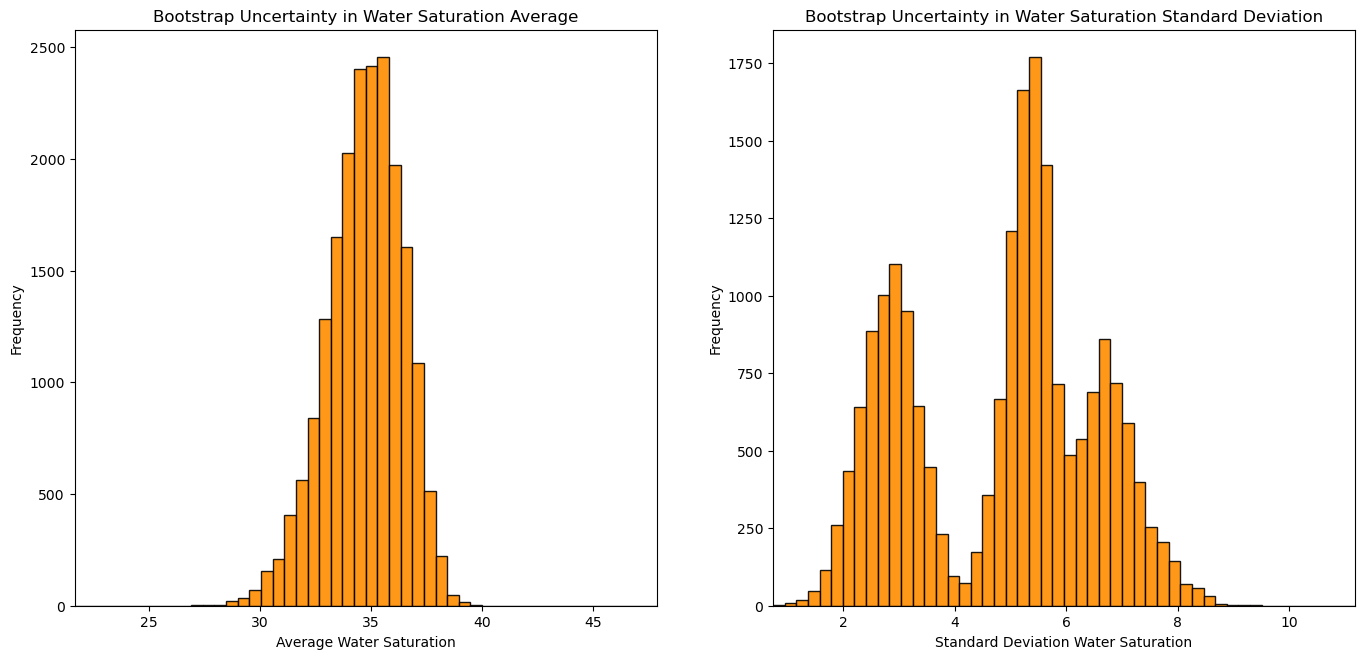

Summary Statistics for Bootstrap Water Saturation Average:
DescribeResult(nobs=20000, minmax=(27.060000000000002, 39.9), mean=34.724660500000006, variance=2.8507152805037728, skewness=-0.4076593730455342, kurtosis=0.10332507225522658)

Uncertainty in Water Saturation Average: P10 32.5%, P50 3484.0%, P90 36.8%

Summary Statistics for Bootstrap Water Saturation Standard Deviation:
DescribeResult(nobs=20000, minmax=(0.9295160030897804, 9.312013745694323), mean=4.83050614629833, variance=2.751322801714145, skewness=-0.15174033273458012, kurtosis=-1.0459693491308737)

Uncertainty in Water Saturation Standard Deviation: P10 2.525%, P50 521.6999999999999%, P90 6.9%


In [10]:
bootstrap(well, 'Water Saturation', 2000, 20000)

100%|█████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 23673.29it/s]


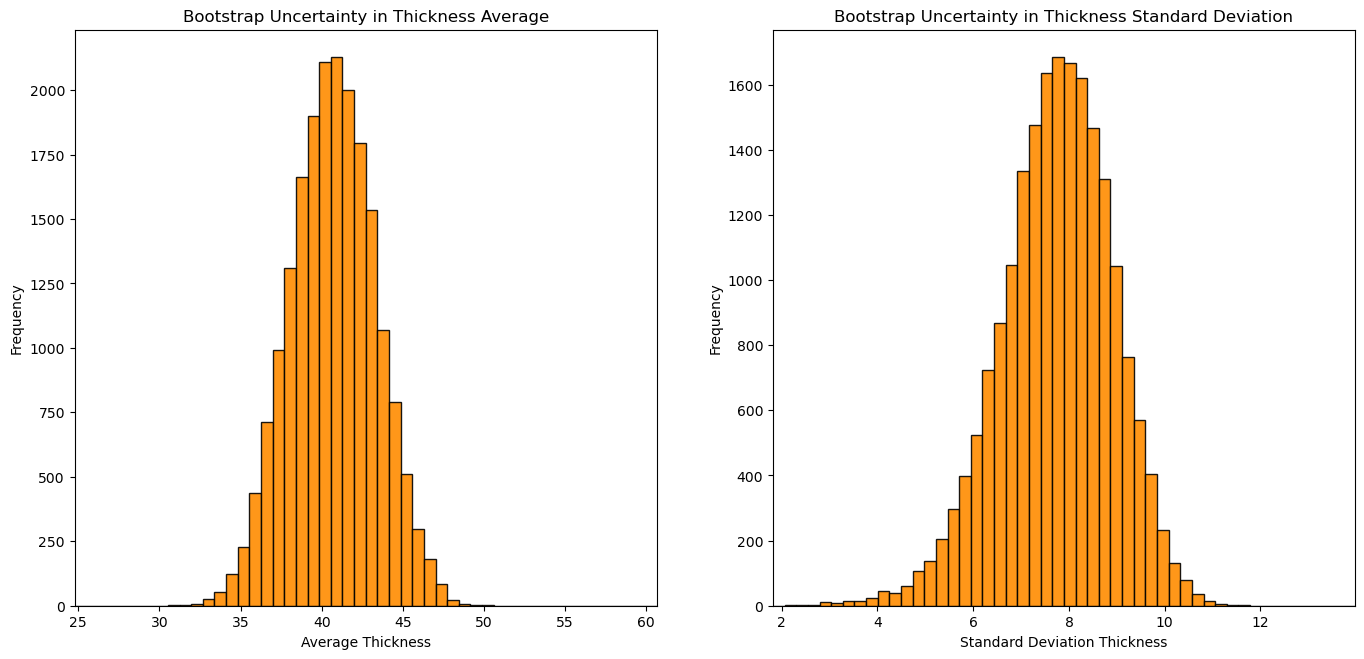

Summary Statistics for Bootstrap Thickness Average:
DescribeResult(nobs=20000, minmax=(30.979999999999997, 50.529999999999994), mean=40.6952345, variance=6.7931792339714505, skewness=-0.016430402546326026, kurtosis=-0.19472613458588484)

Uncertainty in Thickness Average: P10 37.3%, P50 4070.0%, P90 44.1%

Summary Statistics for Bootstrap Thickness Standard Deviation:
DescribeResult(nobs=20000, minmax=(2.2723556059736785, 11.641460389487225), mean=7.740537130960029, variance=1.3624811132847594, skewness=-0.378842346277229, kurtosis=0.40337033755484164)

Uncertainty in Thickness Standard Deviation: P10 6.235%, P50 779.5%, P90 9.2%


In [11]:
bootstrap(well, 'Thickness', 2000, 20000)

In [12]:
# Defining global input parameters for Monte-Carlo simulations

slider_nsample = wid.IntSlider(value=100, min=100, max=100000, description='nsample')
slider_bins = wid.IntSlider(value=100, min=1, max=150, description='bins')
nsample = []
bins = []
slider_nsample.observe(on_change_nsample, names='value')
slider_bins.observe(on_change_bins, names='value')
l = Label('Initiating Global Parameters', layout=Layout(display="flex", justify_content="center"), style={'font_weight': 'bold', 'font_size':'20px'})
ui = wid.HBox([slider_nsample, slider_bins],)
u = wid.VBox([l,ui],)
display(u)

The P90 and P10 of the input parameters are derived from the minimum and maximum of average values from bootstraping respectively. The lower and upper limits are from expert knowledge.


### <center> Summary of the Input Parameters for Monte-Carlo Simulation
| Property | ProbDistribution | Mean | P90 | P10 | Lower Limit | Upper Limit | Peak |
| :- | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| Area (acre) | Truncated Lognormal | -- | 1000 | 3000 | 0 | 5000 | -- |
| Thickness (ft) | Truncated Normal | -- | 25 | 55 | 0 | 100 | -- |
| Porosity (%) | Truncated Normal | -- | 12 | 22 | 5 | 30 | -- |
| Water Saturation (%) | Triangular | -- | -- | -- | 20 | 45 | 30 |
| Volume Factor (ft3/ft3) | Uniform | -- | -- | -- | 1.1 | 1.25 | -- |

In [13]:
area = create_plot_lognormal('Area')

Output()

In [14]:
h = create_plot_normal('Thickness')

Output()

In [15]:
porosity = create_plot_normal('Porosity')

Output()

In [16]:
sw = create_plot_triang('Water Saturation')

Output()

In [17]:
Bo = create_plot_uniform('FVF')

Output()

### <center>Combining the input parameters</center>
The input parameters from the monte carlo simulation provide the oil in-place as output with the uncertainty in the estimate in the form of P90, P10, and the Pmean. The exercise can help in future planning and economic project planning as well. It can also help in understanding the risks associated with a project that can have upfront cost of millions of dollars.

### <center> Summary of the estimated oil in-place from Monte-Carlo Simulation</center>

|Statistics | Value (MMbbl) |
| :- | :-: |
| P90 | 22.7 | 
| Pmean | 58.3 |
| P10 | 104.9 |


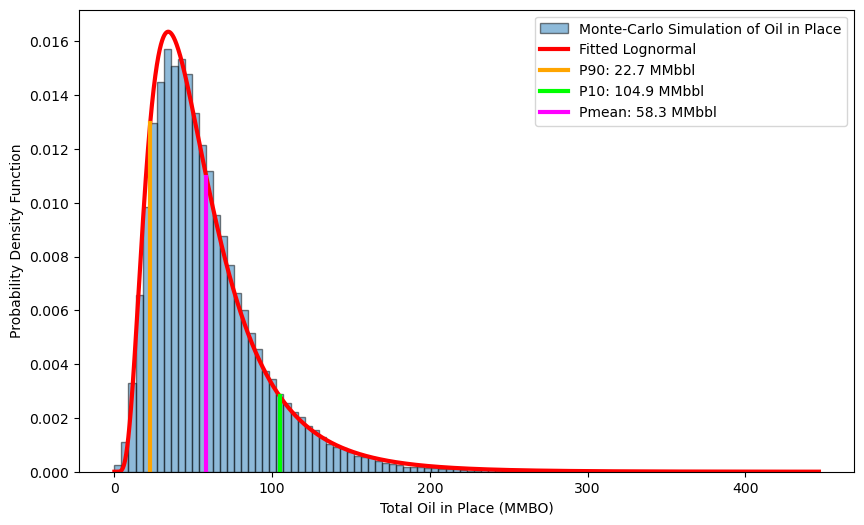

In [18]:
# Calculation Oil in Place with plotting the pdf

net_vol = np.multiply(area,h)
net_reservoir = np.multiply(net_vol, (np.asarray(porosity)/100))
shc = (1-(np.asarray(sw)/100))
net_pay = np.multiply(net_reservoir, shc)
total = np.multiply(net_pay, 1/np.asarray(Bo))
reserves= np.multiply(7758, total)
oil_res = list(np.divide(reserves,1e6))
fig, ax = plt.subplots(figsize=(10,6))
samp_oil, bins_oil, ignored_oil = ax.hist(oil_res, bins=100, density=True, align='mid'
                                         , label='Monte-Carlo Simulation of Oil in Place', alpha=0.5, edgecolor = 'k')
ax.set_xlabel('Total Oil in Place (MMBO)')
ax.set_ylabel('Probability Density Function')
shape, loc, scale  = lognorm.fit(np.asanyarray(oil_res[0]), floc=0)
o = np.linspace(min(np.asanyarray(oil_res[0])), max(np.asanyarray(oil_res[0])), 10000)
pdf_fitted = lognorm.pdf(o, shape, loc=loc, scale=scale)
ax.plot(o, pdf_fitted,'r-', label='Fitted Lognormal', linewidth = 3)

# calculating statistics for the oil in place
cdf_fitted = lognorm.cdf(o, shape, loc=loc, scale=scale)
mean = (np.sum(o*pdf_fitted))* (max(o) - min(o)) / (len(o))
k90 = np.argmin(np.absolute(cdf_fitted - 0.1))
k10 = np.argmin(np.absolute(cdf_fitted - 0.9))
kmean = np.argmin(np.absolute(o - mean))
x_90, x_10 = o[k90], o[k10]
pdf_90, pdf_10, pdf_mean = pdf_fitted[k90], pdf_fitted[k10], pdf_fitted[kmean]
ymin = ax.axes.get_ylim()[0]
ymax = ax.axes.get_ylim()[1]
y_90 = (pdf_90 - ymin) / (ymax-ymin)
y_10 = (pdf_10 - ymin) / (ymax-ymin)
y_mean = (pdf_mean - ymin) / (ymax-ymin)
ax.axvline(x=x_90, ymin=0, ymax=y_90, color='orange', linestyle='-', linewidth = 3, label=('P90: {:,.1f} MMbbl'.format(x_90)))      # plot P90 and P10 on pdf
ax.axvline(x=x_10, ymin=0, ymax=y_10, color='lime', linestyle='-', linewidth = 3, label=('P10: {:,.1f} MMbbl'.format(x_10)))
ax.axvline(x=mean, ymin=0, ymax=y_mean, color='fuchsia', linestyle='-', linewidth = 3, label=('Pmean: {:,.1f} MMbbl'.format(mean)))
ax.legend()
plt.show()

### <center> Impact of Input Parameters on Estimated Oil-In Place </center>
The sensitivity analysis was performed by calculating the correlation coefficient between each of the input parameters and the estimated output. The result provides the sensitivity of the input parameters alongside the direction of impact (positive or negative impact).

**Ranking of impact of the input parameters on the estimated output:**
* Area: positive (0.70)
* Thickness: positive (0.49)
* Porosity: positive (0.38)
* <span style="color:red">Water Saturation: negative (-0.12)</span>
* <span style="color:red">Volume Factor: negative (-0.07)</span>

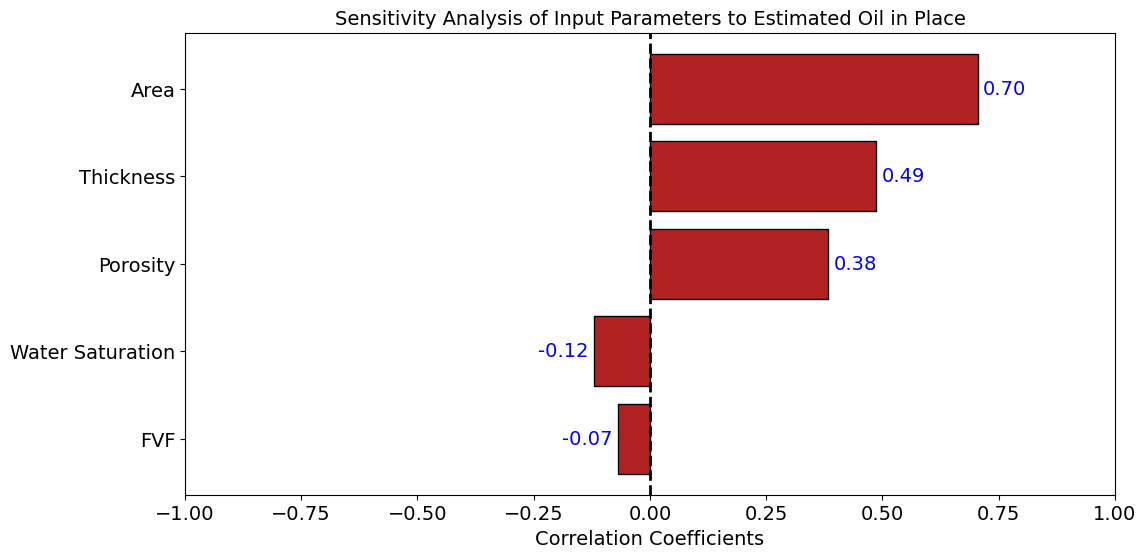

In [19]:
# sensitivity analysis

data = {'Area':area[0], 'Thickness':h[0], 'Porosity':porosity[0], 'Water Saturation':sw[0], 'FVF':Bo[0], 'Oil in Place':reserves[0]}
df = pd.DataFrame(data)
correlation = df[df.columns[0:]].corr()['Oil in Place'][0:-1]
y_pos = np.arange(len(correlation.axes[0]))
value = correlation.array
fig, ax = plt.subplots(figsize=(12,6))
hbars = ax.barh(y_pos, value, align='center', edgecolor='k', color='firebrick')
ax.set_yticks(y_pos)
ax.set_yticklabels(correlation.axes[0])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.invert_yaxis()
ax.axvline(x=0, ymin=0, ymax=1, color='k', linestyle='--', linewidth = 2) 
ax.set_xlabel('Correlation Coefficients', fontsize=14)
ax.set_title('Sensitivity Analysis of Input Parameters to Estimated Oil in Place', fontsize=14)
ax.bar_label(hbars, fmt='%.2f', padding=4, color='b', fontsize=14)
ax.set_xlim(-1,1)
plt.show()